<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/PROCVARCLUS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [2]:
# Install library
!pip install varclushi

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import logit
from varclushi import VarClusHi
from scipy.stats import zscore

# Config
%config InlineBackend.figure_format = 'retina' #Retina display
plt.style.use('seaborn-deep') #Plot style

In [4]:
# Import dependence variable
odr = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/monthlyODR.csv'
)

# Select segment, drop columns
odr = odr.query(
    "Segment == 'CU'"
).drop(
    ['Segment', 'Monthkey'],
    axis = 1
).eval(
    "ODR = Bad / N"
)

# Transform to logit
odr['logitODR'] = logit(odr['ODR'])

# Import macroeconomics data
mev = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/macroTransformed.csv'
)

# Assign date to dependence variable
odr['Date'] = mev['Date']
odr.head(5)

,N,Bad,ODR,logitODR,Date
0,21556,815.0,0.037808,-3.236680,2014-01-01
1,21794,885.0,0.040608,-3.162347,2014-02-01
2,21911,920.0,0.041988,-3.127475,2014-03-01
3,22128,960.0,0.043384,-3.093313,2014-04-01
4,22115,989.0,0.044721,-3.061565,2014-05-01


In [5]:
# Mapping with logit ODR
df = pd.merge(
    odr[['Date', 'logitODR']],
    mev,
    how = 'left',
    left_on = ['Date'],
    right_on = ['Date']
)
df = df.set_index('Date')
df.head(5)

,logitODR,FDI,HD,GDP,RSI,CPI,Wage,UR,OP,Im,Ex,PCI,CCI,API,PII,MPI,PIR,FDI_LN,HD_LN,GDP_LN,RSI_LN,CPI_LN,Wage_LN,UR_LN,OP_LN,Im_LN,Ex_LN,PCI_LN,CCI_LN,API_LN,PII_LN,MPI_LN,PIR_LN,FDI_M3,FDI_M6,FDI_M9,FDI_M12,HD_M3,HD_M6,HD_M9,...,CCI_C_lg9,CCI_C_lg10,CCI_C_lg11,CCI_C_lg12,API_C_lg1,API_C_lg2,API_C_lg3,API_C_lg4,API_C_lg5,API_C_lg6,API_C_lg7,API_C_lg8,API_C_lg9,API_C_lg10,API_C_lg11,API_C_lg12,PII_C_lg1,PII_C_lg2,PII_C_lg3,PII_C_lg4,PII_C_lg5,PII_C_lg6,PII_C_lg7,PII_C_lg8,PII_C_lg9,PII_C_lg10,PII_C_lg11,PII_C_lg12,MPI_C_lg1,MPI_C_lg2,MPI_C_lg3,MPI_C_lg4,MPI_C_lg5,MPI_C_lg6,MPI_C_lg7,MPI_C_lg8,MPI_C_lg9,MPI_C_lg10,MPI_C_lg11,MPI_C_lg12
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01,-3.236680,189417.136534,8.560335e+06,2.381830e+06,212.76,100.15,12911.24,0.94,107.42,637677.49,587085.59,111.37,29.5,150.804689,121.98,100.073269,2.25,12.151707,15.962650,14.683380,5.360165,4.606669,9.465854,-0.061875,4.676746,13.365588,13.282926,4.712858,3.384390,5.015986,4.803857,4.605903,0.810930,188385.514044,189952.931678,189814.358032,190734.781579,8.509564e+06,8.388654e+06,8.280323e+06,...,0.551944,0.499457,0.227784,0.313181,0.033815,-0.006416,-0.012409,0.010903,0.018121,-0.011507,0.006890,-0.005963,-0.042972,-0.053358,-0.052771,-0.041031,-0.021557,-0.025671,-0.026563,-0.006897,-0.015199,-0.022686,-0.043988,-0.038724,0.004171,-0.000974,0.029274,0.151198,-0.093903,-0.102690,-0.061016,-0.028748,-0.013185,-0.008389,0.025905,0.046398,0.089870,0.143477,0.119307,0.239164
2014-02-01,-3.162347,193355.095090,8.576515e+06,2.397283e+06,206.74,100.39,12809.44,0.86,108.81,488289.38,598571.15,102.51,26.7,145.387932,118.41,100.594662,2.25,12.172284,15.964538,14.689847,5.331462,4.609063,9.457938,-0.150823,4.689603,13.098664,13.302301,4.629960,3.284664,4.979406,4.774153,4.611099,0.810930,190038.653875,190305.154152,190079.124929,190886.367688,8.552638e+06,8.452922e+06,8.345568e+06,...,0.380833,0.551944,0.499457,0.227784,0.000948,0.033815,-0.006416,-0.012409,0.010903,0.018121,-0.011507,0.006890,-0.005963,-0.042972,-0.053358,-0.052771,-0.016424,-0.021557,-0.025671,-0.026563,-0.006897,-0.015199,-0.022686,-0.043988,-0.038724,0.004171,-0.000974,0.029274,-0.116277,-0.093903,-0.102690,-0.061016,-0.028748,-0.013185,-0.008389,0.025905,0.046398,0.089870,0.143477,0.119307
2014-03-01,-3.127475,196757.890000,8.589811e+06,2.386443e+06,231.55,100.60,12633.14,0.88,107.40,553252.08,641085.67,118.68,27.5,146.000067,131.07,109.942282,2.00,12.189729,15.966087,14.685315,5.444796,4.611152,9.444079,-0.127833,4.676560,13.223569,13.370918,4.776431,3.314186,4.983607,4.875732,4.699956,0.693147,193176.707208,191032.969152,190993.494929,191044.206021,8.575554e+06,8.507640e+06,8.403359e+06,...,0.348307,0.380833,0.551944,0.499457,-0.027885,0.000948,0.033815,-0.006416,-0.012409,0.010903,0.018121,-0.011507,0.006890,-0.005963,-0.042972,-0.053358,-0.006985,-0.016424,-0.021557,-0.025671,-0.026563,-0.006897,-0.015199,-0.022686,-0.043988,-0.038724,0.004171,-0.000974,-0.058933,-0.116277,-0.093903,-0.102690,-0.061016,-0.028748,-0.013185,-0.008389,0.025905,0.046398,0.089870,0.143477
2014-04-01,-3.093313,198952.610990,8.618880e+06,2.346222e+06,205.79,101.10,13219.29,0.90,107.79,559413.50,556218.79,116.48,29.8,142.590361,119.25,89.339924,2.00,12.200822,15.969466,14.668317,5.326856,4.616110,9.489432,-0.105361,4.680185,13.234644,13.228917,4.757720,3.394508,4.959976,4.781222,4.492448,0.693147,196355.198693,192370.356369,192087.020683,191449.568197,8.595069e+06,8.552316e+06,8.457459e+06,...,0.240180,0.348307,0.380833,0.551944,-0.017446,-0.027885,0.000948,0.033815,-0.006416,-0.012409,0.010903,0.018121,-0.011507,0.006890,-0.005963,-0.042972,-0.018145,-0.006985,-0.016424,-0.021557,-0.025671,-0.026563,-0.006897,-0.015199,-0.022686,-0.043988,-0.038724,0.004171,-0.088659,-0.058933,-0.116277,-0.093903,-0.102690,-0.061016,-0.028748,-0.013185,-0.008389,0.025905,0.046398,0.089870
2014-05-01,-3.061565,200103.269226,8.659787e+06,2.292120e+06,214.25,101.51,13264.39,0.94,1

In [6]:
# Find top 40 by correlation analysis
n = 40
dfCorr = df.corr()

selected = abs(
    dfCorr['logitODR']
).sort_values(
    ascending = False
)[:n].index[1:] #Without 'logitODR'

# Selected DataFrame
df = df[selected]
df.head(5)

,GDP_C_lg12,GDP_C_lg11,MPI_C_lg12,MPI_C_lg11,GDP_C_lg10,RSI_C_lg12,MPI_C_lg10,PCI_C_lg12,PII_M12_lg11,OP_C,PII_M12_lg12,RSI_C_lg11,PII_M12_lg10,GDP_C_lg9,CPI_C,OP_C_lg1,RSI_C_lg10,PII_M12_lg9,API_C_lg8,API_C_lg9,OP_C_lg2,CPI_M9_lg6,CPI_M9_lg5,MPI_C_lg9,API_C_lg7,PIR_C_lg12,CPI_M12_lg4,CPI_M6_lg8,CPI_M6_lg7,CPI_M9_lg7,CPI_M12_lg5,MPI_M12_lg4,MPI_M12_lg5,PII_M12_lg8,Wage_C_lg9,CPI_M6_lg9,CPI_M3_lg10,CPI_M6_lg6,MPI_M12_lg3
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01,0.125214,0.086355,0.239164,0.119307,0.052505,0.165824,0.143477,0.081950,132.205833,-0.050376,131.919167,0.043697,132.195000,0.032748,0.019154,0.008986,0.080085,132.236667,-0.005963,-0.042972,-0.014969,98.541111,98.702222,0.089870,0.006890,-0.25,98.617500,98.486667,98.650000,98.417778,98.501667,106.306109,106.552062,131.815833,0.012343,98.285000,98.410000,98.803333,105.766785
2014-02-01,0.086355,0.052505,0.119307,0.143477,0.032748,0.043697,0.089870,0.029768,132.195000,-0.068460,132.205833,0.080085,132.236667,0.026525,0.019412,-0.050376,0.073149,131.815833,0.006890,-0.005963,0.008986,98.702222,98.838889,0.046398,-0.011507,-0.25,98.736667,98.650000,98.803333,98.541111,98.617500,105.766785,106.306109,131.337500,0.076533,98.486667,98.553333,98.920000,104.861924
2014-03-01,0.052505,0.032748,0.143477,0.089870,0.026525,0.080085,0.046398,0.056690,132.236667,-0.016987,132.195000,0.073149,131.815833,0.026890,0.020893,-0.068460,0.021928,131.337500,-0.011507,0.006890,-0.050376,98.838889,98.976667,0.025905,0.018121,-0.25,98.893333,98.803333,98.920000,98.702222,98.736667,104.861924,105.766785,131.095833,0.067878,98.650000,98.706667,99.053333,104.092542
2014-04-01,0.032748,0.026525,0.089870,0.046398,0.026890,0.073149,0.025905,0.041751,131.815833,0.046622,132.236667,0.021928,131.337500,0.028179,0.024228,-0.016987,-0.006852,131.095833,0.018121,-0.011507,-0.068460,98.976667,99.102222,-0.008389,0.010903,-0.25,99.030000,98.920000,99.053333,98.838889,98.893333,104.092542,104.861924,130.935000,0.072817,98.803333,98.890000,99.188333,103.064226
2014-05-01,0.026525,0.026890,0.046398,0.025905,0.028179,0.021928,-0.008389,0.021510,131.337500,0.062547,131.815833,-0.006852,131.095833,0.027953,0.025846,0.046622,-0.041621,130.935000,0.010903,0.018121,-0.016987,99.102222,99.236667,-0.013185,-0.012409,-0.50,99.188333,99.053333,99.188333,98.976667,99.030000,103.064226,104.092542,130.864167,0.110343,98.920000,99.053333,99.300000,102.555353


### PROC VARCLUS
The PROC VARCLUS procedure is a very useful SAS function for variable reduction / selection. It is based on divisive clustering technique.
1. All variables start in one cluster. Then, the principal components analysis (PCA) has been done on the variables in the single cluster to determine whether the cluster should be split into **2 subsets** or not.
2. If the **second eigenvalue** for the cluster is **greater than** the specified cutoff, then the inital cluster is split into 2 clusters (subset).
3. The meaning of large second eigenvalue is that at least two principal components account for a large amount of variation among the inputs.
4. To determine which inputs are included in each cluster, the principal component scores are rotated obliquely to maximize the correlation within a cluster and minimize the correlation between clusters.
5. The process will be ended when the second eigenvalues of all current clusters are below the cutoff.

In [7]:
# Define PROC VARCLUS object
cluster = VarClusHi(
    df,
    maxeigval2 = 1,
    maxclus = None
)

# Apply cluster object
cluster.varclus()

# Result
result = cluster.rsquare #Return as DataFrame
result['Cluster'] = result['Cluster'] + 1  #To set first number of clusters at 1
result.head(5)

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,1,GDP_C_lg12,0.871101,0.497752,0.256645
1,1,GDP_C_lg11,0.896155,0.745034,0.407289
2,1,MPI_C_lg12,0.858329,0.471213,0.267916
3,1,MPI_C_lg11,0.808024,0.547071,0.423854
4,1,RSI_C_lg12,0.775689,0.668334,0.676318


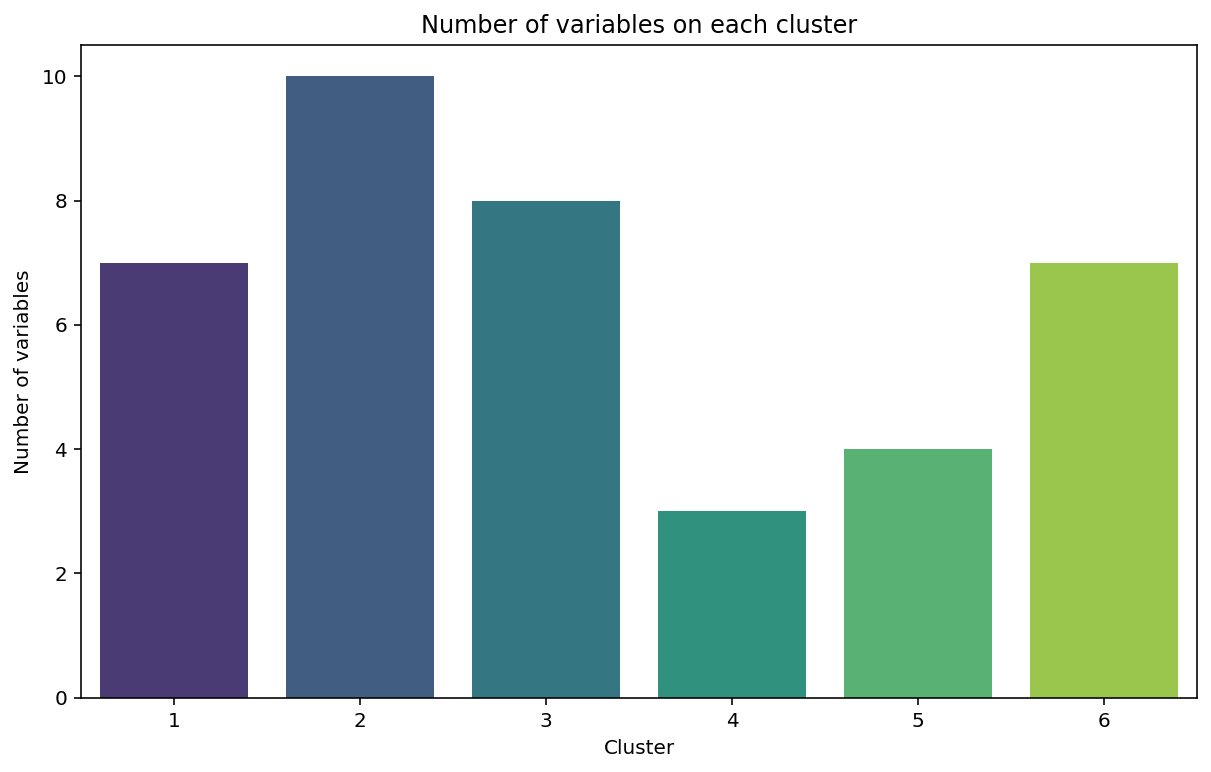

In [8]:
# Count cluster
plt.figure(figsize = (10, 6))
sns.countplot(
    x = 'Cluster',
    data = result,
    palette = 'viridis'
)
plt.title('Number of variables on each cluster')
plt.ylabel('Number of variables')
plt.show()

In [9]:
# Mapping correlation
result = pd.merge(
    result,
    dfCorr['logitODR'].reset_index().rename(
        columns = {
            'index': 'Variable',
            'logitODR': 'Correlation'
        }
    ),
    how = 'left',
    left_on = ['Variable'],
    right_on = ['Variable']
)

# Mapping sub-group of variables
subGroup = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/macroSignTransformed.csv'
) #Import original group prior transformation

result = pd.merge(
    result,
    subGroup[['Variable', 'Group']],
    how = 'left',
    left_on = ['Variable'],
    right_on = ['Variable']
)
result.head(5)

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio,Correlation,Group
0,1,GDP_C_lg12,0.871101,0.497752,0.256645,-0.808461,GDP
1,1,GDP_C_lg11,0.896155,0.745034,0.407289,-0.798710,GDP
2,1,MPI_C_lg12,0.858329,0.471213,0.267916,-0.795060,MPI
3,1,MPI_C_lg11,0.808024,0.547071,0.423854,-0.749703,MPI
4,1,RSI_C_lg12,0.775689,0.668334,0.676318,-0.657134,RSI


### Variables selection
A variable that has the **lowest R-Squared ratio** is likely to be a good representative for the cluster. It means maximum correlation with own cluster and minimum correlation with next cluster. Additionally, the variables, which has the high correlation seem to be a good predictor for regression model.

Both of these might be used with cluster number and sub-group of variables condition. By selecting 1 with lowest R-Square ratio and 1 with highest correlation on **each cluster and each sub-group**.

In [10]:
# Variables selection
result['Correlation'] = abs(result['Correlation']) #Absolute correlation

# Rank variable based on cluster and group
result['RSRatioRank'] = result.groupby(
    ['Cluster', 'Group']
)['RS_Ratio'].rank(
    method = 'first',
    ascending = True
) #Low to high

result['correlationRank'] = result.groupby(
    ['Cluster', 'Group']
)['Correlation'].rank(
    method = 'first',
    ascending = False
) #High to low

# Show
result.head(5)

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio,Correlation,Group,RSRatioRank,correlationRank
0,1,GDP_C_lg12,0.871101,0.497752,0.256645,0.808461,GDP,1.0,1.0
1,1,GDP_C_lg11,0.896155,0.745034,0.407289,0.798710,GDP,2.0,2.0
2,1,MPI_C_lg12,0.858329,0.471213,0.267916,0.795060,MPI,1.0,1.0
3,1,MPI_C_lg11,0.808024,0.547071,0.423854,0.749703,MPI,2.0,2.0
4,1,RSI_C_lg12,0.775689,0.668334,0.676318,0.657134,RSI,1.0,1.0


In [11]:
# Selection based on lowest R-Square ratio and highest correlation on each cluster and group
result['select'] = np.where(
    (
        (result['RSRatioRank'] == 1) | \
        (result['correlationRank'] == 1)
    ),
    1,
    0
)

result = result.query(
    "select == 1"
)

# Show
result.head(5)

# Export
result.to_csv(
    'clusterVarClusResult.csv',
    index = False
)

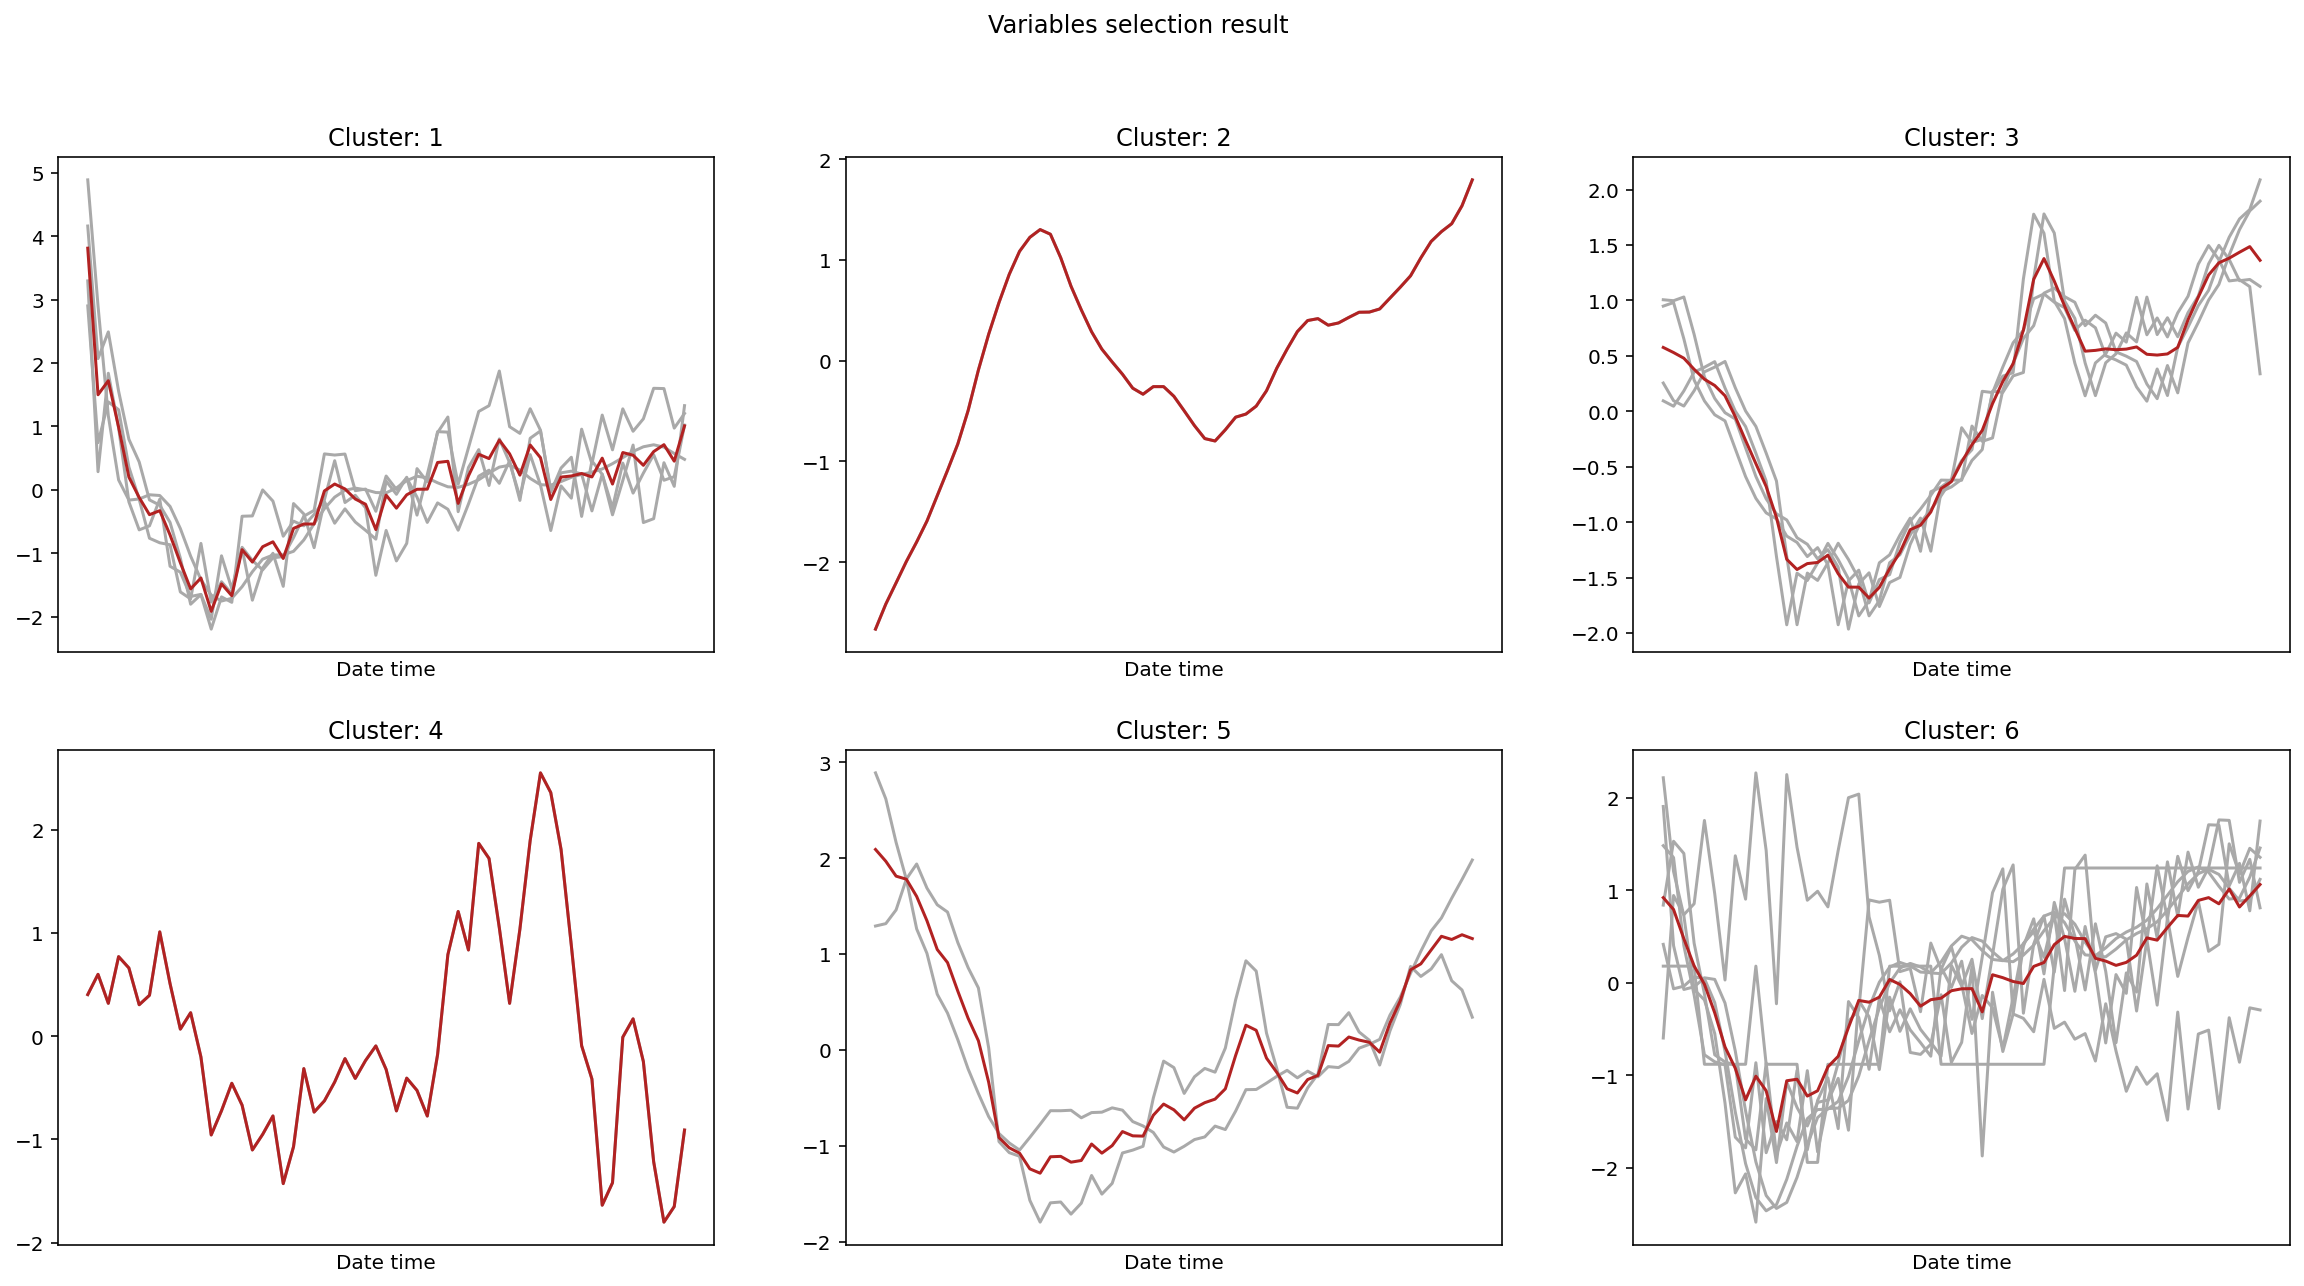

In [12]:
# Plot
fig, axs = plt.subplots(
    2, 3,
    figsize = (20, 10), 
    sharex = True
)
axs = axs.ravel()
fig.suptitle('Variables selection result')
for cluster in sorted(result['Cluster'].unique()):
  varList = list(
      result.query(
          "Cluster == @cluster"
      )['Variable']
  )
  dataPlot = zscore(df[varList]) #Change basis to Z-Score
  dataMeanPlot = dataPlot.mean(axis = 1)
  axs[cluster - 1].plot(dataPlot, color = 'darkgray')
  axs[cluster - 1].plot(dataMeanPlot, color = 'firebrick')
  axs[cluster - 1].set_title(f'Cluster: {cluster}')
  axs[cluster - 1].set_xticks([])
  axs[cluster - 1].set(xlabel = 'Date time', ylabel = '')
plt.show()